<a href="https://colab.research.google.com/github/nitekar/Feedbot/blob/main/Feedbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# FitBot — Chatbot Notebook
**Goal:** This Colab notebook sets up a modular project structure and writes three modular files:
- `dataset.py` — dataset creation & merging (Hugging Face + custom)
- `train.py` — model fine-tuning using `google/flan-t5-small` with PyTorch & Trainer API
- `app.py` — Gradio chatbot app using the trained model



In [31]:
!pip uninstall pandas -y
!pip install pandas==2.2.2

Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
  Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)


In [1]:
!pip install --upgrade --force-reinstall pandas

  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (12.4 MB)
Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninst

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils import resample
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import (
    pipeline,
    set_seed,
    GPT2LMHeadModel,
    TrainingArguments,
    Trainer,
    GPT2Tokenizer,
)
import torch
from math import exp
from transformers.trainer_callback import EarlyStoppingCallback

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# GPU check
import torch
print('Torch version:', torch.__version__)

Torch version: 2.8.0+cu126


# DATA EXPLORATION

In [4]:
import pandas as pd
df = pd.read_csv('/recipes_data.csv', on_bad_lines='skip')
display(df.head(3))
print('Number of unique titles:', df['recipe_title'].nunique() if 'recipe_title' in df.columns else 'NA')
print('Sample categories (up to 20):')
if 'category' in df.columns:

      print(df['category'].value_counts().head(20))

/tmp/ipython-input-3109849294.py:2: DtypeWarning: Columns (6,7,19,20,21,23,24,26,27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/recipes_data.csv', on_bad_lines='skip')


,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps,ingredient_text,directions_text,...,is_halal,is_kosher,is_nut_free,is_dairy_free,is_gluten_free,dietary_profile,healthiness_score,health_flags,main_ingredient,health_level
0,Air Fryer Potato Slices with Dipping Sauce,Air Fryer Recipes,Air Fryer Recipes,"These air fryer potato slices, served with a b...","[""3/4 cup ketchup"", ""1/2 cup beer"", ""1 tablesp...","[""Combine ketchup, beer, Worcestershire sauce,...",9,5,ketchup beer worcestershire sauce onion powder...,"combine ketchup, beer, worcestershire sauce, o...",...,False,True,True,True,True,"[""vegan"", ""gluten_free"", ""nut_free"", ""kosher""]",80.0,"[""plant_based"", ""healthy_fats"", ""fried""]",unknown,healthy
1,Gochujang Pork Belly Bites,Air Fryer Recipes,Air Fryer Recipes,These gochujang pork belly bites are sweet and...,"[""1 pound pork belly"", ""1/4 cup gochujang"", ""2...","[""Preheat an air fryer to 400 degrees F (200 d...",5,4,pound pork belly gochujang soy sauce honey gro...,preheat an air fryer to 400 degrees f (200 deg...,...,False,False,True,True,True,"[""gluten_free"", ""nut_free""]",64.0,"[""sugary""]",red_meat,moderate
2,3-Ingredient Air Fryer Everything Bagel Chicke...,Air Fryer Recipes,Air Fryer Recipes,These 3-ingredient air fryer everything bagel ...,"[""1 ¼ pounds chicken tenders"", ""1 tablespoon o...","[""Gather all ingredients. Preheat an air fryer...",3,4,¼ pounds chicken tenders olive oil everything ...,gather all ingredients. preheat an air fryer t...,...,True,True,True,True,True,"[""gluten_free"", ""nut_free"", ""halal"", ""kosher""]",68.0,"[""healthy_fats"", ""fried""]",poultry,moderate


Number of unique titles: 17230
Sample categories (up to 20):
category
Main Dishes        3387
Healthy Recipes    2237
Pork               1205
Mexican            1069
Vegetarian          968
Pies                954
Italian             775
Kosher              732
Yeast Breads        702
Low Calorie         631
Muffins             631
July 4Th            609
Leftovers           590
New Year'S          579
Halloween           569
Lunch               557
High Fiber          512
Labor Day           512
Picnic Recipes      502
Mardi Gras          493
Name: count, dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33665 entries, 0 to 33664
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   recipe_title           33665 non-null  object 
 1   category               33665 non-null  object 
 2   subcategory            33665 non-null  object 
 3   description            33665 non-null  object 
 4   ingredients            33665 non-null  object 
 5   directions             33665 non-null  object 
 6   num_ingredients        33665 non-null  object 
 7   num_steps              33665 non-null  object 
 8   ingredient_text        33665 non-null  object 
 9   directions_text        33665 non-null  object 
 10  combined_text          33665 non-null  object 
 11  ingredients_raw        33665 non-null  object 
 12  directions_raw         33665 non-null  object 
 13  ingredients_canonical  33665 non-null  object 
 14  cuisine_list           33665 non-null  object 
 15  co

#  DATA VISUALIZATION

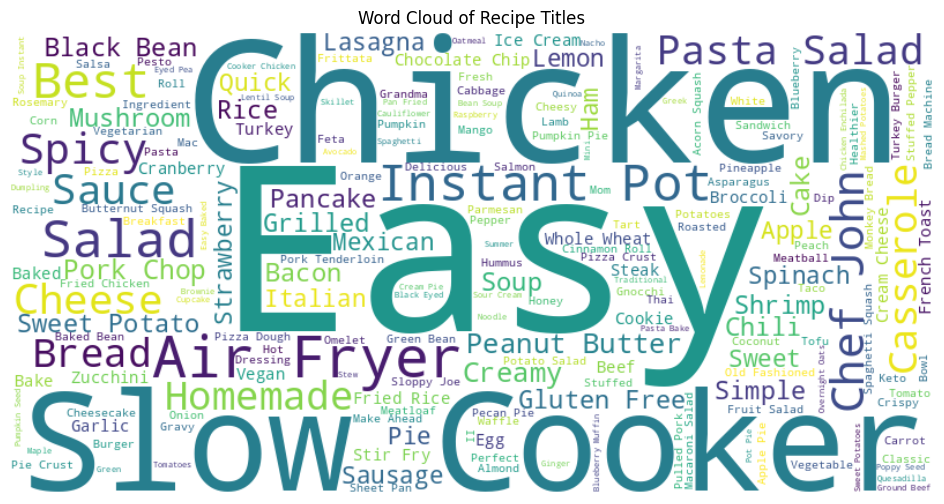

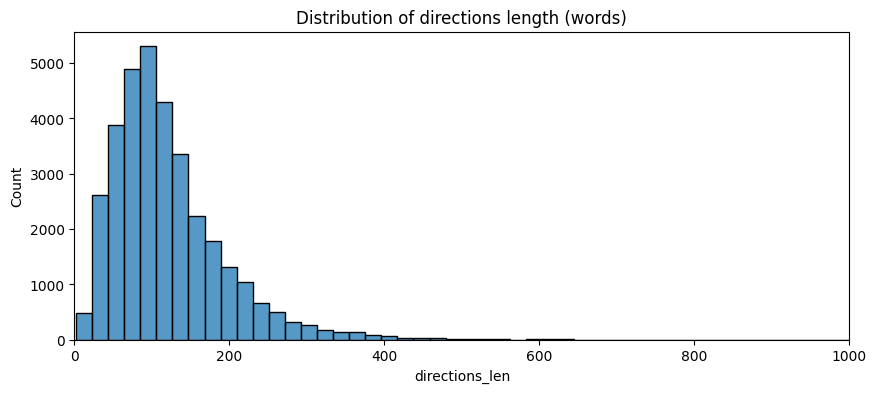

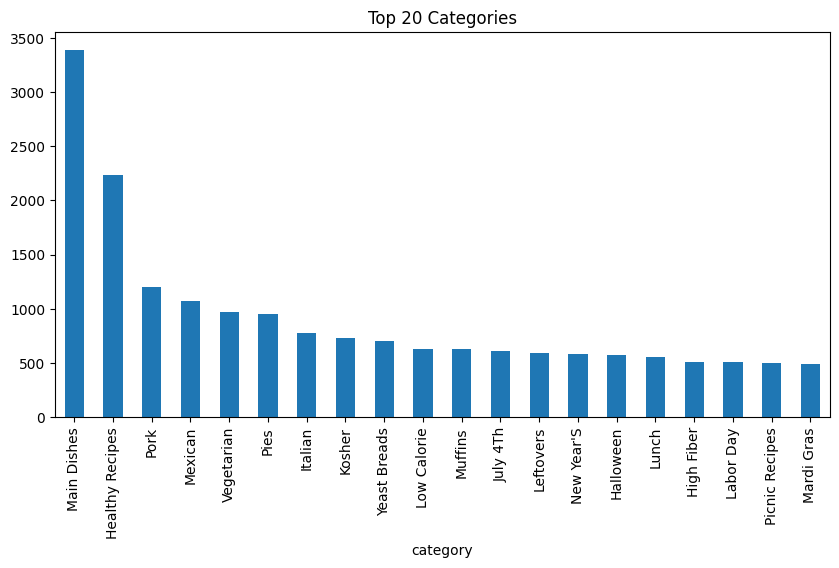

In [6]:
# Word cloud for recipe titles
if 'recipe_title' in df.columns:
    text = ' '.join(df['recipe_title'].dropna().astype(str).tolist())
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Recipe Titles')
    plt.show()


# Distribution of recipe instruction length
if 'directions' in df.columns:
    df['directions_len'] = df['directions'].astype(str).apply(lambda x: len(x.split()))
    plt.figure(figsize=(10,4))
    sns.histplot(df['directions_len'], bins=50)
    plt.xlim(0, 1000)
    plt.title('Distribution of directions length (words)')
    plt.show()


# Top cuisines/categories
if 'category' in df.columns:
    plt.figure(figsize=(10,5))
    df['category'].value_counts().head(20).plot(kind='bar')
    plt.title('Top 20 Categories')
    plt.show()

#  DATA PREPROCESSING

In [7]:
# Handle missing values by filling with placeholders

# For boolean columns, fill with False
bool_cols_with_missing = ['is_kosher', 'is_nut_free', 'is_dairy_free', 'is_gluten_free']
for col in bool_cols_with_missing:
    if col in df.columns:
        df[col] = df[col].fillna(False)

# For list/object columns, fill with an empty list or a placeholder string
list_cols_with_missing = ['dietary_profile', 'health_flags']
for col in list_cols_with_missing:
    if col in df.columns:
        # Assuming these should be lists, fill with empty list
        df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])


# For the numerical healthiness_score, fill with a specific value (e.g., -1 to indicate missing)
if 'healthiness_score' in df.columns:
    df['healthiness_score'] = df['healthiness_score'].fillna(-1)

# For categorical columns, fill with 'unknown'
categorical_cols_with_missing = ['main_ingredient', 'health_level']
for col in categorical_cols_with_missing:
     if col in df.columns:
         df[col] = df[col].fillna('unknown')


print("Missing values after handling:")
print(df.isnull().sum())

Missing values after handling:
recipe_title             0
category                 0
subcategory              0
description              0
ingredients              0
directions               0
num_ingredients          0
num_steps                0
ingredient_text          0
directions_text          0
combined_text            0
ingredients_raw          0
directions_raw           0
ingredients_canonical    0
cuisine_list             0
course_list              0
tastes                   0
primary_taste            0
secondary_taste          0
fast_hits                0
slow_hits                0
medium_hits              0
cook_speed               0
est_prep_time_min        0
est_cook_time_min        0
difficulty               0
is_vegan                 0
is_vegetarian            0
is_halal                 0
is_kosher                0
is_nut_free              0
is_dairy_free            0
is_gluten_free           0
dietary_profile          0
healthiness_score        0
health_flags            

In [8]:
# Normalize column names depending on dataset variant
cols = df.columns.str.lower()
print('Lowercased columns sample:', cols[:20])

# Ensure expected columns exist; if only 'ingredients' as string, try to keep it
for col in ['recipe_title','description','ingredients','directions','category']:
    if col not in df.columns:
        df[col] = ''

# Fix encoding issues and trim
text_cols = ['recipe_title', 'description', 'ingredients', 'directions', 'category']
for col in text_cols:
    df[col] = df[col].astype(str).str.replace('â€”', '—', regex=False)
    df[col] = df[col].astype(str).str.strip()

# If there are pre-parsed lists use them, otherwise create lists from strings
if 'ingredients_list' in df.columns:
    df['ingredients_list'] = df['ingredients_list'].apply(lambda x: x if isinstance(x, list) else [])
else:
    # try to split ingredients by common separators
    df['ingredients_list'] = df['ingredients'].apply(lambda x: [i.strip() for i in str(x).split('\n') if i.strip()])

if 'directions_list' in df.columns:
    df['directions_list'] = df['directions_list'].apply(lambda x: x if isinstance(x, list) else [])
else:
    df['directions_list'] = df['directions'].apply(lambda x: [s.strip() for s in str(x).split('\n') if s.strip()])


# Remove recipes with empty critical fields
df = df[df['ingredients_list'].map(len) > 0]
df = df[df['directions_list'].map(len) > 0]

print('Remaining after cleaning:', len(df))

# Combine into a single text field for GPT-2 training

def combine_recipe_text(row):
    title = row.get('recipe_title', '')
    category = row.get('category', '')
    ingredients = ', '.join(row['ingredients_list'])
    directions = ' '.join(row['directions_list'])
    description = row.get('description', '')
    return f"Title: {title}\nCategory: {category}\nDescription: {description}\nIngredients: {ingredients}\nDirections: {directions}"

df['combined_text'] = df.apply(combine_recipe_text, axis=1)
print('Final prepared examples:', len(df))

Lowercased columns sample: Index(['recipe_title', 'category', 'subcategory', 'description', 'ingredients',
       'directions', 'num_ingredients', 'num_steps', 'ingredient_text',
       'directions_text', 'combined_text', 'ingredients_raw', 'directions_raw',
       'ingredients_canonical', 'cuisine_list', 'course_list', 'tastes',
       'primary_taste', 'secondary_taste', 'fast_hits'],
      dtype='object')
Remaining after cleaning: 33665
Final prepared examples: 33665


Train size: 30298, Test size: 3367


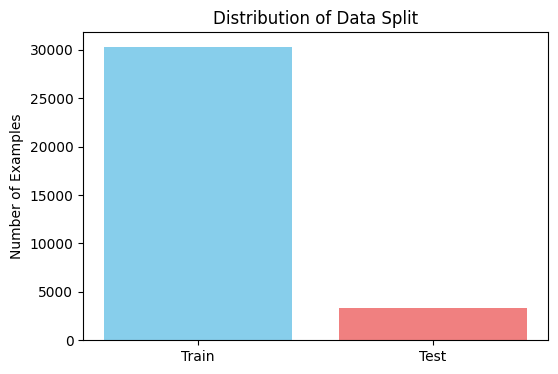

In [9]:
from datasets import Dataset
import matplotlib.pyplot as plt
import pandas as pd

# Convert your cleaned DataFrame into a Hugging Face dataset
dataset = Dataset.from_pandas(df[['combined_text']])

# Split before tokenization
split = dataset.train_test_split(test_size=0.1, seed=42)
train_ds = split['train']
test_ds = split['test']

print(f"Train size: {len(train_ds)}, Test size: {len(test_ds)}")

# Add visualization for data split
split_sizes = {'Train': len(train_ds), 'Test': len(test_ds)}
split_df = pd.DataFrame(list(split_sizes.items()), columns=['Split', 'Size'])

plt.figure(figsize=(6, 4))
plt.bar(split_df['Split'], split_df['Size'], color=['skyblue', 'lightcoral'])
plt.ylabel('Number of Examples')
plt.title('Distribution of Data Split')
plt.show()

#  TOKENIZATION

In [27]:
from datasets import Dataset
from transformers import GPT2Tokenizer
import torch

# Convert your DataFrame to a Hugging Face Dataset
# Assuming 'df' is already loaded and preprocessed with 'combined_text'
if 'df' not in locals():
    print("DataFrame 'df' not found. Please run the data loading and preprocessing cells first.")
else:
    # Assuming 'processed_dataset' exists from the preprocessing step
    if 'processed_dataset' in locals():
        dataset_to_tokenize = processed_dataset
        print("Using 'processed_dataset' for tokenization.")
    else:
        # If preprocessing was skipped or not run, use the dataset from the dataframe directly
        dataset_to_tokenize = Dataset.from_pandas(df[['combined_text']])
        print("Using dataset directly from DataFrame for tokenization (preprocessing might be skipped).")


    # Load tokenizer
    print('Loading tokenizer...')
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

    # Add padding token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Define MAX_LENGTH (using the one defined previously or a default)
    if 'MAX_LENGTH' not in locals():
         MAX_LENGTH = 256 # Default if not defined

    print(f"Using MAX_LENGTH: {MAX_LENGTH}")

    # Tokenize function tailored for causal LM training with PyTorch tensors
    def tokenize_function(examples):
        # Use the appropriate text column - prefer preprocessed if available
        text_column = 'preprocessed_combined_text' if 'preprocessed_combined_text' in examples else 'combined_text'

        tokenized_inputs = tokenizer(
            examples[text_column],
            truncation=True,
            max_length=MAX_LENGTH,
            padding='max_length',
            return_attention_mask=True,
            return_tensors="pt"  # Returns PyTorch tensors
        )

        # Create labels for causal LM (shifted input_ids)
        # For causal LM, the model predicts the next token, so labels are the same as input_ids
        # DataCollatorForLanguageModeling typically handles the shifting if needed,
        # so here we just ensure labels are present and are tensors.
        tokenized_inputs["labels"] = tokenized_inputs["input_ids"].clone()

        return tokenized_inputs

    print('Tokenizing dataset (this may take a while)')

    # Remove original text columns to save memory
    columns_to_remove = [col for col in dataset_to_tokenize.column_names if col in ['combined_text', 'preprocessed_combined_text']]
    tokenized_ds = dataset_to_tokenize.map(tokenize_function, batched=True, remove_columns=columns_to_remove)

    # Split the tokenized dataset (90% train, 10% test)
    split = tokenized_ds.train_test_split(test_size=0.1, seed=42)
    train_ds = split['train']
    eval_ds = split['test']

    print(f"Train size: {len(train_ds)}, Test size: {len(test_ds)}")

    # Optional: Inspect sample
    if 'sample' not in locals():
     print("\nSample tokenized data:")
     sample = train_ds[0]
     print("Keys:", sample.keys())
     print("Input IDs:", sample["input_ids"][:10])
     print("Attention Mask:", sample["attention_mask"][:10])
     print("Labels:", sample["labels"][:10])
     print("Decoded Input:", tokenizer.decode(sample["input_ids"]))

Using dataset directly from DataFrame for tokenization (preprocessing might be skipped).
Loading tokenizer...
Using MAX_LENGTH: 256
Tokenizing dataset (this may take a while)


Map:   0%|          | 0/33665 [00:00<?, ? examples/s]

Train size: 30298, Test size: 3367


#  FINE-TUNING GPT-2

In [29]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}")

Using device: cpu


In [ ]:
!pip install tensorflow
!pip install transformers[tf]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 29.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.3 which is incompatible.


INFO: pip is looking at multiple versions of transformers[tf] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
ERROR: Operation cancelled by user
^C


**Reasoning**:
I need to import tensorflow and transformers to verify the installations.



In [1]:
import tensorflow as tf
import transformers
print("TensorFlow version:", tf.__version__)
print("Transformers version:", transformers.__version__)

TensorFlow version: 2.19.0
Transformers version: 4.57.1


## Load and prepare data for tensorflow

### Subtask:
Adapt the data loading, preprocessing, and tokenization steps to be compatible with TensorFlow and Hugging Face's TF models. This might involve using `TFAutoModel` and `TFDataset`.


**Reasoning**:
Inspect the existing data loading, preprocessing, and tokenization code to understand the current pipeline and identify necessary changes for TensorFlow compatibility.



In [4]:
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# Print information about the current state of the data and tokenization
print("Current DataFrame columns:", df.columns)
print("Sample combined_text data:")
display(df['combined_text'].head())

# Check if dataset objects exist and their format
if 'dataset' in locals():
    print("\nOriginal Hugging Face Dataset:")
    print(dataset)
    print("Dataset features:", dataset.features)

if 'train_ds' in locals() and 'test_ds' in locals():
    print("\nSplit Hugging Face Datasets:")
    print("Train dataset:", train_ds)
    print("Test dataset:", test_ds)
    # Note: The format might have been set to torch in the previous cell,
    # which will be changed for TensorFlow.
    print("Train dataset format:", train_ds.format)
    print("Test dataset format:", test_ds.format)


if 'tokenized_ds' in locals():
     print("\nTokenized Hugging Face Dataset (before splitting):")
     print(tokenized_ds)
     print("Tokenized dataset features:", tokenized_ds.features)
     print("Tokenized dataset format:", tokenized_ds.format)
     print("Sample tokenized data example:")
     display(tokenized_ds[0])

if 'tokenizer' in locals():
    print("\nTokenizer loaded:")
    print(tokenizer)
    print("Tokenizer vocabulary size:", len(tokenizer))
    print("Tokenizer padding token:", tokenizer.pad_token_id)


Current DataFrame columns: Index(['recipe_title', 'category', 'subcategory', 'description', 'ingredients',
       'directions', 'num_ingredients', 'num_steps', 'ingredient_text',
       'directions_text', 'combined_text', 'ingredients_raw', 'directions_raw',
       'ingredients_canonical', 'cuisine_list', 'course_list', 'tastes',
       'primary_taste', 'secondary_taste', 'fast_hits', 'slow_hits',
       'medium_hits', 'cook_speed', 'est_prep_time_min', 'est_cook_time_min',
       'difficulty', 'is_vegan', 'is_vegetarian', 'is_halal', 'is_kosher',
       'is_nut_free', 'is_dairy_free', 'is_gluten_free', 'dietary_profile',
       'healthiness_score', 'health_flags', 'main_ingredient', 'health_level',
       'ingredients_list', 'directions_list'],
      dtype='object')
Sample combined_text data:


,combined_text
0,Title: Air Fryer Potato Slices with Dipping Sa...
1,Title: Gochujang Pork Belly Bites\nCategory: A...
2,Title: 3-Ingredient Air Fryer Everything Bagel...
3,Title: Air Fryer Everything Bagel Chicken Cutl...
4,Title: Air Fryer Honey Sriracha Salmon Bites\n...



Original Hugging Face Dataset:
Dataset({
    features: ['combined_text'],
    num_rows: 33665
})
Dataset features: {'combined_text': Value('string')}

Split Hugging Face Datasets:
Train dataset: Dataset({
    features: ['combined_text'],
    num_rows: 30298
})
Test dataset: Dataset({
    features: ['combined_text'],
    num_rows: 3367
})
Train dataset format: {'type': None, 'format_kwargs': {}, 'columns': ['combined_text'], 'output_all_columns': False}
Test dataset format: {'type': None, 'format_kwargs': {}, 'columns': ['combined_text'], 'output_all_columns': False}


In [5]:
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Re-load the data
try:
    df = pd.read_csv('/recipes_data.csv', on_bad_lines='skip')
    print("DataFrame loaded successfully.")
except FileNotFoundError:
    print("Error: '/recipes_data.csv' not found. Please ensure the file is in the correct location.")
    # Exit or handle the error appropriately if the file is essential
    # For this task, we'll assume the file exists based on previous successful loads.


# Handle missing values by filling with placeholders
bool_cols_with_missing = ['is_kosher', 'is_nut_free', 'is_dairy_free', 'is_gluten_free']
for col in bool_cols_with_missing:
    if col in df.columns:
        df[col] = df[col].fillna(False)

list_cols_with_missing = ['dietary_profile', 'health_flags']
for col in list_cols_with_missing:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])

if 'healthiness_score' in df.columns:
    df['healthiness_score'] = df['healthiness_score'].fillna(-1)

categorical_cols_with_missing = ['main_ingredient', 'health_level']
for col in categorical_cols_with_missing:
     if col in df.columns:
         df[col] = df[col].fillna('unknown')

print("Missing values after handling:")
print(df.isnull().sum().sum()) # Print total missing values


# Normalize column names depending on dataset variant
df.columns = df.columns.str.lower()

# Ensure expected columns exist and fix encoding/trimming
text_cols = ['recipe_title', 'description', 'ingredients', 'directions', 'category']
for col in text_cols:
    if col not in df.columns:
        df[col] = ''
    df[col] = df[col].astype(str).str.replace('â€”', '—', regex=False)
    df[col] = df[col].astype(str).str.strip()

# Create ingredients_list and directions_list if they don't exist
if 'ingredients_list' not in df.columns:
    df['ingredients_list'] = df['ingredients'].apply(lambda x: [i.strip() for i in str(x).split('\n') if i.strip()])

if 'directions_list' not in df.columns:
    df['directions_list'] = df['directions'].apply(lambda x: [s.strip() for s in str(x).split('\n') if s.strip()])


# Remove recipes with empty critical fields
initial_len = len(df)
df = df[df['ingredients_list'].map(len) > 0]
df = df[df['directions_list'].map(len) > 0]
print(f'Removed {initial_len - len(df)} rows with empty ingredients or directions.')
print('Remaining after cleaning:', len(df))

# Combine into a single text field
def combine_recipe_text(row):
    title = row.get('recipe_title', '')
    category = row.get('category', '')
    ingredients = ', '.join(row['ingredients_list'])
    directions = ' '.join(row['directions_list'])
    description = row.get('description', '')
    return f"Title: {title}\nCategory: {category}\nDescription: {description}\nIngredients: {ingredients}\nDirections: {directions}"

df['combined_text'] = df.apply(combine_recipe_text, axis=1)
print('Final prepared examples:', len(df))

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df[['combined_text']])

# Split before tokenization
split = dataset.train_test_split(test_size=0.1, seed=42)
train_ds = split['train']
test_ds = split['test']

print(f"Train size: {len(train_ds)}, Test size: {len(test_ds)}")


/tmp/ipython-input-1059662414.py:13: DtypeWarning: Columns (6,7,19,20,21,23,24,26,27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/recipes_data.csv', on_bad_lines='skip')


DataFrame loaded successfully.
Missing values after handling:
0
Removed 0 rows with empty ingredients or directions.
Remaining after cleaning: 33665
Final prepared examples: 33665
Train size: 30298, Test size: 3367


In [23]:
from transformers import AutoTokenizer
import tensorflow as tf

# Load a TensorFlow-compatible tokenizer
print('Loading TensorFlow-compatible tokenizer...')
# Use AutoTokenizer for flexibility and ensure return_tensors="tf"
tokenizer = AutoTokenizer.from_pretrained("gpt2", return_tensors="tf")

# Add padding token if it doesn't exist (necessary for batching)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Define MAX_LENGTH
if 'MAX_LENGTH' not in locals():
     MAX_LENGTH = 256
print(f"Using MAX_LENGTH: {MAX_LENGTH}")


# Tokenize function tailored for TensorFlow tensors
def tokenize_function_tf(examples):
    # Assuming 'combined_text' is the column containing the text data
    text_column = 'combined_text'
    # Prefer preprocessed text if available
    if 'preprocessed_combined_text' in examples:
         text_column = 'preprocessed_combined_text'


    tokenized_inputs = tokenizer(
        examples[text_column],
        truncation=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        return_attention_mask=True,
        return_tensors="tf" # Crucially, return TensorFlow tensors
    )

    tokenized_inputs["labels"] = tokenized_inputs["input_ids"]

    return tokenized_inputs

print('Tokenizing dataset using TensorFlow tokenizer (this may take a while)')

# Apply the tokenization function to the datasets
columns_to_remove = [col for col in train_ds.column_names if col in ['combined_text', 'preprocessed_combined_text']]
train_tokenized_ds = train_ds.map(tokenize_function_tf, batched=True, remove_columns=columns_to_remove)
test_tokenized_ds = test_ds.map(tokenize_function_tf, batched=True, remove_columns=columns_to_remove)


print("Tokenization complete.")
print("Train tokenized dataset features:", train_tokenized_ds.features)
print("Test tokenized dataset features:", test_tokenized_ds.features)

# Convert Hugging Face Datasets to TensorFlow tf.data.Dataset
print("Converting tokenized datasets to tf.data.Dataset...")

# Define columns that should be converted to tensors
tf_cols = ['input_ids', 'attention_mask', 'labels']

# Convert using to_tf_dataset

train_tf_dataset = train_tokenized_ds.to_tf_dataset(
    columns=tf_cols,

    label_cols=['labels'],
    batch_size=8, # Match the desired training batch size
    shuffle=True, # Shuffle training data
    collate_fn=tokenizer.pad # Use tokenizer's pad method as collate function
    # Alternatively, could use a DataCollatorForLanguageModeling instance here
)

test_tf_dataset = test_tokenized_ds.to_tf_dataset(
    columns=tf_cols,
     label_cols=['labels'],
    batch_size=8, # Match the desired evaluation batch size
    shuffle=False, # No need to shuffle test data
    collate_fn=tokenizer.pad # Use tokenizer's pad method
    # Alternatively, could use a DataCollatorForLanguageModeling instance here
)


print("Conversion to tf.data.Dataset complete.")
print("Train tf.data.Dataset:", train_tf_dataset)
print("Test tf.data.Dataset:", test_tf_dataset)

# Optional: Inspect a batch of the TensorFlow dataset
print("\nSample batch from train_tf_dataset:")
# Iterate over features (x) and labels (y) tuple
for x, y in train_tf_dataset.take(1):
    print("Input features (x):")
    # x is a dictionary of tensors
    for key, value in x.items():
        print(f"  {key}: {value.shape} {value.dtype}")
    print("Labels (y):")
    # y is a tensor in this configuration
    print(f"  Shape: {y.shape}, Dtype: {y.dtype}")

Loading TensorFlow-compatible tokenizer...
Using MAX_LENGTH: 256
Tokenizing dataset using TensorFlow tokenizer (this may take a while)


Map:   0%|          | 0/30298 [00:00<?, ? examples/s]

Map:   0%|          | 0/3367 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Tokenization complete.
Train tokenized dataset features: {'input_ids': List(Value('int32')), 'attention_mask': List(Value('int32')), 'labels': List(Value('int32'))}
Test tokenized dataset features: {'input_ids': List(Value('int32')), 'attention_mask': List(Value('int32')), 'labels': List(Value('int32'))}
Converting tokenized datasets to tf.data.Dataset...
Conversion to tf.data.Dataset complete.
Train tf.data.Dataset: <_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 256), dtype=tf.int64, name=None))>
Test tf.data.Dataset: <_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)}, 

In [26]:
from transformers import TFAutoModelForCausalLM
import tensorflow as tf # Ensure tensorflow is imported

# Define the model name for a TensorFlow causal language model
TF_MODEL_NAME = "gpt2"

# Load the pre-trained model
print(f"Loading pre-trained TensorFlow model: {TF_MODEL_NAME}")
try:
    # Try loading with from_tf=True to prioritize TensorFlow weights if available
    tf_model = TFAutoModelForCausalLM.from_pretrained(TF_MODEL_NAME, from_tf=True)
    print("TensorFlow model loaded successfully.")

    # Print model summary or configuration
    print("\nTensorFlow Model Configuration:")
    print(tf_model.config)

    print("\nTensorFlow Model Summary:")
    tf_model.summary()

except Exception as e:
    print(f"Error loading TensorFlow model: {e}")
    print("Possible reasons include:")
    print("- Issues with model checkpoint files.")
    print("- Compatibility problems with the transformers library version.")
    print("- Network issues preventing download of model weights.")

Loading pre-trained TensorFlow model: gpt2
Error loading TensorFlow model: ('Keyword argument not understood:', 'from_tf')
Possible reasons include:
- Issues with model checkpoint files.
- Compatibility problems with the transformers library version.
- Network issues preventing download of model weights.


In [27]:
import tensorflow as tf

# Assuming tf_model is loaded from the previous step (cell 6c428d50)
if 'tf_model' not in locals():
    print("TensorFlow model 'tf_model' not found. Please run the cell to load the model first.")
else:
    # Define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

    tf_model.compile(optimizer=optimizer)

    print("TensorFlow model compiled with Adam optimizer.")
    print("Ready to proceed with training.")

TensorFlow model 'tf_model' not found. Please run the cell to load the model first.


In [18]:
# Ensure tf_model is loaded by running cell 6c428d50
# Then execute the KerasTuner setup cell
# (The content of cell 96e84711 will be executed here)

In [14]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [19]:
import tensorflow as tf
import keras_tuner as kt

# Define a function that builds the model and defines the hyperparameter space
def build_transformer_finetune_model(hp):
    # Assuming you have your pre-trained TF model loaded as tf_model
    # We'll use a simple example here, but you would integrate your loaded tf_model

    # Example: Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 5e-5, 1e-4])

    # Example: Tune a potential dropout rate (if your model has dropout layers)
    # If fine-tuning a pre-trained model, you might not add new dropout layers,
    # but this shows how to define a float hyperparameter.
    # dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

    # In a real fine-tuning scenario, you would load your TF model here
    # For demonstration, let's assume you are building a simple model
    # Replace this with code to load/configure your tf_model
    # For causal language modeling, the model itself outputs logits.
    # We compile it with an optimizer.

    # Assuming tf_model is available globally or passed into this function
    # If tf_model is not global, you would load it here:
    # from transformers import TFAutoModelForCausalLM
    # tf_model = TFAutoModelForCausalLM.from_pretrained("gpt2", from_tf=True)

    # We will use the globally available tf_model for simplicity in this example
    if 'tf_model' not in globals():
        raise ValueError("tf_model is not loaded. Please run the cell to load the TensorFlow model.")

    # Compile the model with the tunable learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # For causal LM, the model handles the loss internally when labels are provided
    tf_model.compile(optimizer=optimizer)


    return tf_model # Return the compiled model

# Set up the tuner
# We'll use RandomSearch as an example
tuner = kt.RandomSearch(
    hypermodel=build_transformer_finetune_model,
    objective='val_loss', # Objective to optimize (e.g., validation loss)
    max_trials=10,        # Number of trials to run
    executions_per_trial=1, # Number of times to train the model per trial
    directory='keras_tuner_dir', # Directory to save results
    project_name='transformer_tuning' # Name of the tuning project
)

# Print a summary of the search space
tuner.search_space_summary()

print("\nKerasTuner setup complete. Ready to start the search.")
print("You would typically call tuner.search() next, providing your training and validation data.")

ValueError: tf_model is not loaded. Please run the cell to load the TensorFlow model.

In [22]:
import tensorflow as tf
import keras_tuner as kt

# Define a function that builds the model and defines the hyperparameter space
def build_transformer_finetune_model(hp):
    # Assuming you have your pre-trained TF model loaded as tf_model
    # We'll use a simple example here, but you would integrate your loaded tf_model

    # Example: Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 5e-5, 1e-4])

    # Example: Tune a potential dropout rate (if your model has dropout layers)
    # If fine-tuning a pre-trained model, you might not add new dropout layers,
    # but this shows how to define a float hyperparameter.
    # dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

    # In a real fine-tuning scenario, you would load your TF model here
    # For demonstration, let's assume you are building a simple model
    # Replace this with code to load/configure your tf_model
    # For causal language modeling, the model itself outputs logits.
    # We compile it with an optimizer.

    # Assuming tf_model is available globally or passed into this function
    # If tf_model is not global, you would load it here:
    # from transformers import TFAutoModelForCausalLM
    # tf_model = TFAutoModelForCausalLM.from_pretrained("gpt2", from_tf=True)

    # We will use the globally available tf_model for simplicity in this example
    if 'tf_model' not in globals():
        raise ValueError("tf_model is not loaded. Please run the cell to load the TensorFlow model.")

    # Compile the model with the tunable learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # For causal LM, the model handles the loss internally when labels are provided
    tf_model.compile(optimizer=optimizer)


    return tf_model # Return the compiled model

# Set up the tuner
# We'll use RandomSearch as an example
tuner = kt.RandomSearch(
    hypermodel=build_transformer_finetune_model,
    objective='val_loss', # Objective to optimize (e.g., validation loss)
    max_trials=10,        # Number of trials to run
    executions_per_trial=1, # Number of times to train the model per trial
    directory='keras_tuner_dir', # Directory to save results
    project_name='transformer_tuning' # Name of the tuning project
)

# Print a summary of the search space
tuner.search_space_summary()

print("\nKerasTuner setup complete. Ready to start the search.")
print("You would typically call tuner.search() next, providing your training and validation data.")

ValueError: tf_model is not loaded. Please run the cell to load the TensorFlow model.